In [ ]:
%matplotlib inline
# disable rescaling the figure, to gain tighter control over the result
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [ ]:
import itertools as it
import math
import os.path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.model_selection as sk_model_selection
import tensorflow as tf

from scipy.ndimage import gaussian_filter1d
from python_speech_features import mfcc

from mlsup import Loop
from mlsup.label import listdata
from mlsup.plot import mpl_set, change_vspan, change_plot

from kwdetect.model import load_data, Model, predict_single
from kwdetect.segmentation import compute_speechiness
from kwdetect.util import (
    as_confusion_matrix, 
    encoding_to_category, 
    label_decoding, 
    label_encoding, 
    load_sample, 
    play_file,
    show_graph,
)

In [ ]:
data = listdata('./data/*.ogg')

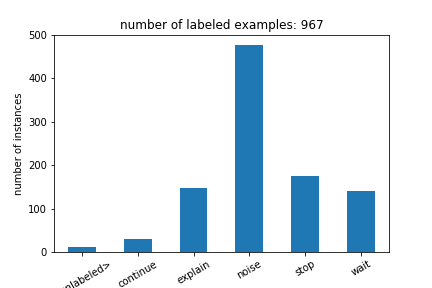

In [ ]:
df = pd.DataFrame(data)

df.groupby('label').size().sort_index().plot.bar(rot=30)
plt.ylabel('number of instances')
plt.title(f'number of labeled examples: {(df["label"] != "<unlabeled>").sum()}')
pass

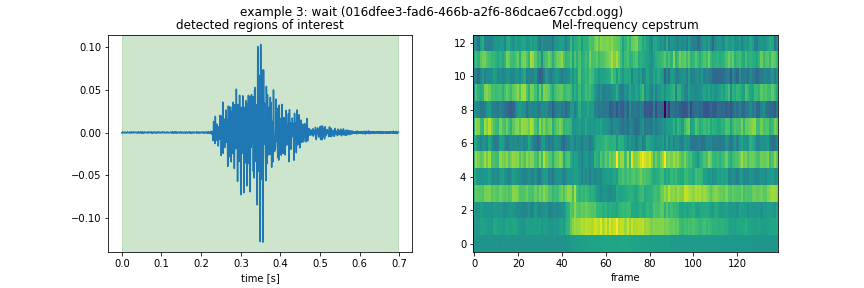

In [ ]:
def _plot(idx=0, data=data):
    samplerate = 44100
    
    sample = load_sample(data[idx]['file'])    
    in_speech, blocks = compute_speechiness(sample, samplerate=samplerate, in_speech=False)
    
    time = np.arange(len(sample)) / samplerate
    features = mfcc(sample, 44100, winlen=10e-3, winstep=5e-3, numcep=13)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(time[::10], sample[::10])
    
    for block in blocks:
        plt.axvspan(time[np.min(block)], time[np.max(block)], alpha=0.2, color='g')
    
    plt.title(f'detected regions of interest')
    plt.xlabel('time [s]')
    
    plt.subplot(1, 2, 2)
    plt.imshow(features.T, aspect='auto', interpolation='none', origin='lower')
    plt.title('Mel-frequency cepstrum')
    plt.xlabel('frame')
    
    plt.suptitle(f'example {idx}: {data[idx]["label"]} ({os.path.basename(data[idx]["file"])})')
    
    plt.show()
    
_plot(3)

# Model

In [ ]:
labeled_data = [d for d in data if d['label'] in label_encoding]
labels = np.asarray([label_encoding[d['label']] for d in labeled_data])

train_idx, test_idx = sk_model_selection.train_test_split(
    np.arange(len(labeled_data)), test_size=0.15, stratify=labels,
)

train_data = [labeled_data[i] for i in train_idx]
test_data = [labeled_data[i] for i in test_idx]

(test_inputs, test_lengths, test_labels), = load_data(test_data, batch_size=None)

In [ ]:
print(f'Number of train examples {len(train_data)}, number of test examples {len(test_data)}')

Number of train examples 821, number of test examples 146


In [ ]:
tf.reset_default_graph()
model = Model(learning_rate=1e-4)

In [ ]:
svg = show_graph(
    exclude={'conv1d*', 'rnn', 'training', 'dense'}, 
    style={('inputs', 'lengths', 'labels'): "shape=rect"},
    skip_recurrence=True,
)
with open('img/model.svg', 'w') as fobj:
    fobj.write(svg.data)

## Model description

The model is 

- a stack of convolutional layers, alternating between dense and dilated convolutions,
- followed by a recurrent layer as a pooling function
- and a dense layer to determine class logits

![Model graph](./img/model.svg)

## Training

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [ ]:
saver = tf.train.Saver(max_to_keep=3)

n_epochs = 30
batch_size = 10
n_batches = len(train_data) // batch_size
losses = []
test_loss = math.nan
iteration = 0

print(f'train for {n_epochs} epochs ...')

loop = Loop()
for epoch in range(n_epochs):
    batches = load_data(train_data, batch_size=batch_size)
    for batch, (inputs, lengths, labels) in loop(enumerate(batches), length=n_batches):
        loss = model.fit_partial({'inputs': inputs, 'lengths': lengths}, labels, session=sess)
        losses.append([iteration, epoch, batch, loss, math.nan])
        iteration += 1
        print(f'{loop} {epoch + 1}/{batch + 1}: {loss:.4f}, {test_loss:.4f}'.ljust(120), end='\r')
        
    saver.save(sess, './run/model/state', global_step=epoch)
    
    test_loss = sess.run(
        model.loss_, 
        {model.inputs_: test_inputs, model.lengths_: test_lengths, model.labels_: test_labels},
    )
    losses[-1][-1] = test_loss

losses = np.asarray(losses)
print()
print('predict ...')

train_results = []

for batch, (inputs, lengths, labels) in enumerate(load_data(train_data)):
    pred = model.predict({'inputs': inputs, 'lengths': lengths}, session=sess)
    train_results += zip(pred, labels)
    print(f'predict for batch {batch + 1}'.ljust(120), end='\r')
print()

test_results = list(zip(
    model.predict({'inputs': test_inputs, 'lengths': test_lengths}, session=sess),
    test_labels
))

train for 30 epochs ...
[⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿ 1m 57s / 1m 57s] 30/82: 0.0249, 0.1512                                                                      
predict ...
predict for batch 82                                                                                                    


In [ ]:
print('pickle model to', './run/model/model.pickle')
with open('./run/model/model.pickle', 'wb') as fobj:
    pickle.dump(model.to_pickable(sess), fobj)

pickle model to ./run/model/model.pickle


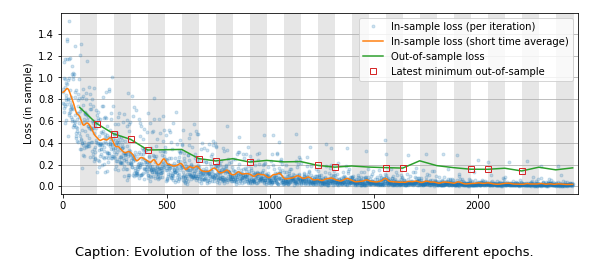

In [ ]:
mask = np.isfinite(losses[:, 4])

plt.figure(figsize=(8.45, 3.6))
plt.subplots_adjust(left=0.1, right=.95, bottom=0.25, top=0.95)

change_vspan(losses[:, 0], losses[:, 1])

plt.plot(losses[:, 0], losses[:, 3], '.', alpha=0.2, label='In-sample loss (per iteration)')
plt.plot(losses[:, 0], gaussian_filter1d(losses[:, 3], 10), label='In-sample loss (short time average)')

plt.plot(losses[mask, 0], losses[mask, 4], '-', label='Out-of-sample loss')

change_plot(
    losses[:, 0], losses[:, 4], 
    transform_y=np.minimum.accumulate, marker='s', mfc='none', ls='none',
    label='Latest minimum out-of-sample',
) 

plt.grid(True, axis='y')
plt.grid(False, axis='x')

mpl_set(
    legend=dict(loc='upper right', facecolor='w'),
    xlabel='Gradient step', ylabel='Loss (in sample)',
    xlim=(-10, 1.01 * len(losses)),
    caption='''
        Caption: Evolution of the loss. 
        The shading indicates different epochs. 
    ''',
)

plt.savefig('./img/keyword_training_curve.png', dpi=75)
pass

## Results

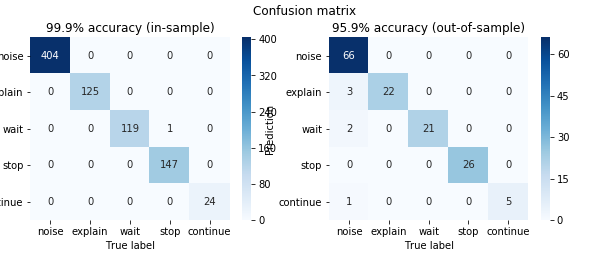

In [ ]:
def _plot_confusion_matrix(df):
    return (
        df
        .pipe(encoding_to_category(label_decoding, ['Prediction', 'True label']))
        .pipe(as_confusion_matrix('True label', 'Prediction'))
        .T
        .pipe(sns.heatmap, annot=True, fmt='d', cmap='Blues')
    )

plt.figure(figsize=(8.45, 3.6))
plt.subplots_adjust(left=0.05, right=0.95, bottom=0.15, top=0.855)
plt.subplot(1, 2, 1)
df = pd.DataFrame(train_results, columns=['Prediction', 'True label'])
plt.title(f'{(df["Prediction"] == df["True label"]).mean():.1%} accuracy (in-sample)')
df.pipe(_plot_confusion_matrix)

plt.subplot(1, 2, 2)
df = pd.DataFrame(test_results, columns=['Prediction', 'True label'])
plt.title(f'{(df["Prediction"] == df["True label"]).mean():.1%} accuracy (out-of-sample)')
df.pipe(_plot_confusion_matrix)

plt.suptitle('Confusion matrix')

plt.savefig('./img/keyword_confusion.png', dpi=75)

pass

# Test the fitted model with live examples

In [ ]:
import time

import sounddevice as sd
import soundfile as sf

from kwdetect.model import prepare_samples
from kwdetect.segmentation import compute_speechiness
from kwdetect.util import DEFAULT_SAMPLERATE, unique_filename

In [ ]:
examples = []

In [ ]:
# wait to skip keyboard tones
time.sleep(0.1)

# record an example
print('speak ...')
sample = sd.rec(DEFAULT_SAMPLERATE * 2, DEFAULT_SAMPLERATE, channels=1, blocking=True)
examples.append(sample)

# and predict its class
predict_single(model, sample, sess)

In [ ]:
# save the examples as further training data
for s in examples:
    if s.ndim == 2:
        s = np.mean(s, axis=1)
    _, blocks = compute_speechiness(s)
    
    if len(blocks) != 1:
        print('skip')
    
    else:
        s = s[blocks[0]]
        fname = unique_filename('data', '{}.ogg')
        print('write', fname)
        sf.write(fname, s, samplerate=DEFAULT_SAMPLERATE)